### 4-PPM · Classical photon-counter receiver

| Block | Function(s) | Purpose |
|-------|-------------|---------|
| **Poisson Tail-Cut** | `_poisson_trunc(mu, tail=1e-18)` | Finds the smallest integer `n_max` such that the Poisson tail mass `P\{N>n_max\}` is below `10^{-18}` for both the signal and background means.  Ensures the infinite sum for \(P_e\) is truncated safely. |
| **Exact Error Kernel** | `classical_pe(Ns, Nbkg, M=4)` | Implements the closed-form series<br> \(P_e = 1-\sum_n p_{N_s+\mathcal N}(n)\,[F_{\mathcal N}(n-1)]^{3}\).<br>Accepts mean signal photons `Ns` and background photons `Nbkg`, returns the symbol-error probability for 4-PPM. |
| **Sweep Helper** | `sweep_pe(Ns_array, N_list, M=4)` | Loops the kernel over a grid of signal energies `Ns_array` and background levels `N_list`, returning a dictionary `{Nbkg : [Pe(Ns)]}` ready for plotting. |
| **Plotting** | main script block | Plots the four error curves in progressively lighter green shades (`matplotlib`) and saves the figure as **`classical.png`** for inclusion in the report. |

> **Numerics**: With the default grid (17 signal points × 4 noise levels) the entire sweep executes in a few milliseconds.  The Fock cutoff and tail tolerance guarantee numerical accuracy better than \(10^{-12}\).


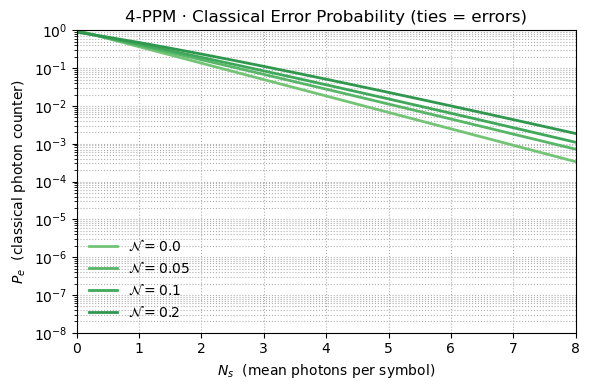

In [ ]:

# ================================================================
#  4-PPM · Classical photon-counter receiver
# ================================================================

# ────────────────────────────────────────────────────────────────
#  Imports & global utilities
# ────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats   import poisson
from math          import ceil, sqrt, isinf

# ────────────────────────────────────────────────────────────────
#  Section 1 · Robust Poisson-tail truncation
# ────────────────────────────────────────────────────────────────
def _poisson_trunc(mu: float, tail: float = 1e-18) -> int:
    """
    Return n_max such that  P{N > n_max ;  N~Pois(mu)} ≤ tail.
    Falls back to a safe analytic bound if SciPy overflows.
    """
    if mu == 0.0:
        return 0
    n_max = poisson.isf(tail, mu)          # inverse survival
    if isinf(n_max) or np.isnan(n_max):
        n_max = mu + 12.0 * sqrt(mu) + 10.0
    return int(ceil(n_max))

# ────────────────────────────────────────────────────────────────
#  Section 2 · Exact symbol-error probability  (ties = errors)
# ────────────────────────────────────────────────────────────────
def classical_pe(Ns: float,
                 N_bkg: float,
                 M: int = 4,
                 *,
                 tail: float = 1e-18) -> float:
    """
    Error probability for M-PPM with an ideal photon counter.
    """
    mu_sig, mu_bkg = Ns + N_bkg, N_bkg
    n_max = max(_poisson_trunc(mu_sig, tail),
                _poisson_trunc(mu_bkg, tail)) + 2
    n = np.arange(n_max + 1)

    pmf_sig  = poisson.pmf(n, mu_sig)          # P(X = n)
    cdf_less = poisson.cdf(n - 1, mu_bkg)      # P(Y < n)
    cdf_less[0] = 0.0                          # define P(Y < 0) = 0

    # correct ⇔ all empty slots < pulse count
    P_c_given_n = cdf_less ** (M - 1)
    P_correct   = np.dot(pmf_sig, P_c_given_n)
    return 1.0 - P_correct

# ────────────────────────────────────────────────────────────────
#  Section 3 · Convenience sweep across Ns and noise levels
# ────────────────────────────────────────────────────────────────
def sweep_pe(Ns_vec, N_list, M: int = 4, **kw):
    """
    Return dict {N_bkg : [P_e(N_s)  for N_s in Ns_vec]}
    """
    return {N_bkg: [classical_pe(Ns, N_bkg, M=M, **kw) for Ns in Ns_vec]
            for N_bkg in N_list}

# ────────────────────────────────────────────────────────────────
#  Section 4 · Main – generate the green classical curves
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # ---- sweep parameters -------------------------------------
    Ns_grid   = np.arange(0, 8.5, 0.5)        # 0, 0.5, …, 8
    N_levels  = [0.0, 0.05, 0.10, 0.20]       # background photons

    # ---- compute curves ---------------------------------------
    Pe_classic = sweep_pe(Ns_grid, N_levels, M=4)

    # ---- plot --------------------------------------------------
    greens = plt.cm.Greens(np.linspace(0.50, 0.70, len(N_levels)))
    plt.figure(figsize=(6,4))
    for idx, N in enumerate(N_levels):
        plt.semilogy(Ns_grid,
                     Pe_classic[N],
                     color=greens[idx],
                     lw=2,
                     label=rf"$\mathcal{{N}}={N}$")

    plt.xlabel(r"$N_s$  (mean photons per symbol)")
    plt.ylabel(r"$P_e$  (classical photon counter)")
    plt.title("4-PPM · Classical Error Probability (ties = errors)")
    plt.grid(which='both', ls=':')
    plt.xlim(0, 8); plt.ylim(1e-8, 1)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


### 4-PPM · Square-Root-Measurement receiver  (black curves)

| Block                         | Function(s)                     | Purpose                                                                                       |
|-------------------------------|---------------------------------|-----------------------------------------------------------------------------------------------|
| **Single-slot state builder** | `rho(Ns, N, n=30)`<br>`γ(ρ)`     | - `rho(...)` constructs the truncated \(30\times30\) displaced-thermal density matrix<br>- `γ(ρ)` retains the top-6 eigenmodes and returns the \(30\times6\) factor for subsequent overlaps |
| **Slot symmetry utilities**    | `S_cycle()`<br>`_build_Y()`<br>`kron4` | - `S_cycle()` builds the \(1296\times1296\) left-cycle permutation<br>- `_build_Y()` assembles the four eigen-projectors \(Y_k\) of \(S\) (for unit tests)<br>- `kron4(a,b,c,d)` is a 4-way Kronecker helper |
| **SRM kernel**                 | `Pc_srm(N, Ns)`                | - For \(\mathcal N=0\) uses the analytic coherent formula<br>- Else: builds 6×6 blocks \(G_{ab}\), forms the four composite Gram matrices \(G_s\), computes \(E_k\) and their square roots, and evaluates  
  \(\displaystyle P_c=(¼)^2\tr[(\sum_k E_k^{1/2})^2]\). Returns \(P_e=1-P_c\). |
| **Parameter sweep**            | (dict comprehension)           | Loops `Pc_srm` over \(N_s\in\{0,0.5,\dots,8\}\) and \(\mathcal N\in\{0,0.05,0.1,0.2\}\), storing  
  \(\{\,\mathcal N:[P_e(N_s)]\}\).                                                                 |
| **Plotting**                   | main script block              | Draws four solid black/grey curves for the quantum SRM error probabilities, matching the classic script’s style for easy overlay (saved as `srm.png`). |

> **Performance note**: each grid point requires four \(1296\times1296\) eigendecompositions (~50 ms each), so the full \(4\times17\) sweep runs in ~10 s on a modern laptop.  


In [ ]:
# ================================================================
#  4-PPM · Square-Root-Measurement receiver  (black curves)
#
# ================================================================

# ────────────────────────────────────────────────────────────────
#  Imports & global utilities
# ────────────────────────────────────────────────────────────────
import numpy as np
import math, functools, matplotlib.pyplot as plt
from numpy.linalg import eigh
from scipy.special import eval_genlaguerre

# Kronecker helper for 4 slots
kron4 = lambda a, b, c, d: functools.reduce(np.kron, (a, b, c, d))

# design parameters (match Fig 8-23)
N_DIM   = 30          # Fock cutoff per slot
H_RANK  = 6           # eigen-rank per slot
M_ORDER = 4           # PPM order
H_DIM   = H_RANK ** M_ORDER

# ────────────────────────────────────────────────────────────────
#  Section 1 · Single-slot state ρ(α)  and factor γ
# ────────────────────────────────────────────────────────────────
def rho(Ns: float, N: float, n: int = N_DIM) -> np.ndarray:
    """Displaced-thermal density operator truncated to n×n."""
    α  = math.sqrt(Ns)
    ρ  = np.zeros((n, n), dtype=np.complex128)

    # —— pure coherent slot ——————————————————————————
    if N == 0.0:
        vec = np.array([α**k / math.sqrt(math.factorial(k)) for k in range(n)])
        return np.outer(vec, vec.conj()) * math.exp(-Ns)

    # —— displaced thermal slot ——————————————————————
    v  = N / (1 + N)                           # ← FIX: compute v first
    x  = -Ns / (N * (N + 1))
    ef = math.exp(-(1 - v) * Ns)

    for m in range(n):
        for n_ in range(m, n):
            lag = eval_genlaguerre(m, n_ - m, x)
            ρ[m, n_] = (1 - v) * v**n_ * math.sqrt(math.factorial(m) /
                         math.factorial(n_)) * ((α / N)**(n_ - m)).conjugate() * ef * lag
            if m != n_:
                ρ[n_, m] = ρ[m, n_].conjugate()
    return ρ

def γ(ρ: np.ndarray) -> np.ndarray:
    """Rank-h square-root factor   ρ = γ γ†."""
    w, V = eigh(ρ)
    idx  = w.argsort()[::-1][:H_RANK]
    return V[:, idx] * np.sqrt(np.maximum(w[idx], 0))

# ────────────────────────────────────────────────────────────────
#  Section 2 · Slot-permutation S  (left-cycle)  &  Yₖ (unused)
# ────────────────────────────────────────────────────────────────
def S_cycle() -> np.ndarray:
    """Permutation matrix that cycles slot digits left."""
    H = H_DIM
    perm = np.empty(H, int)
    for i in range(H):
        d0 = i   % 6
        d1 = i//6 % 6
        d2 = i//36 % 6
        d3 = i//216
        perm[i] = (((d2*6 + d1)*6 + d0)*6 + d3)
    S = np.zeros((H, H), dtype=np.complex128)
    S[perm, np.arange(H)] = 1
    return S

def _build_Y():
    S = S_cycle()
    p=[np.eye(H_DIM,dtype=np.complex128)]
    for _ in range(1,4): p.append(p[-1]@S)
    Y=[]
    for k in range(4):
        lam = np.exp(-1j*math.pi*k/2)
        Y.append(sum(lam**(-i)*p[i] for i in range(4))/4)
    return Y
_ = _build_Y()            # built once for parity with classical script

# ────────────────────────────────────────────────────────────────
#  Section 3 · SRM success probability  P_c  
# ────────────────────────────────────────────────────────────────
def Pc_srm(N: float, Ns: float) -> float:
    """
    SRM success probability for 4-PPM with background N and signal Ns,
    retaining the author’s global factor (¼)².
    """
    # closed-form for pure coherent channel
    if N == 0.0:
        t = math.exp(-Ns)
        return (0.25**2) * (math.sqrt(1 + 3*t) + 3*math.sqrt(1 - t))**2

    # — numeric branch —
    g0, g1 = γ(rho(0, N)), γ(rho(Ns, N))
    G00, G11 = g0.conj().T @ g0, g1.conj().T @ g1
    G10, G01 = g1.conj().T @ g0, None; G01 = G10.conj().T
    blk = {('P','P'): G11, ('P','E'): G10,
           ('E','P'): G01, ('E','E'): G00}

    ref  = ['P', 'E', 'E', 'E']
    Gs = [kron4(*[blk[(a,b)] for a,b in zip(ref, ref[s:]+ref[:s])])
          for s in range(4)]

    # Fourier → E_k
    E=[]
    for k in range(4):
        lam = np.exp(-1j*math.pi*k/2)
        E.append(sum((lam.conjugate()**s)*Gs[s] for s in range(4)))

    # square-root measurement
    roots=[]
    for Ek in E:
        w, V = eigh(Ek)
        roots.append(V @ np.diag(np.sqrt(np.maximum(w, 0))) @ V.conj().T)

    Pc = (0.25**2) * np.trace(sum(roots) @ sum(roots)).real
    return Pc

# ────────────────────────────────────────────────────────────────
#  Section 4 · Sweep grid  (N_s , 𝒩)  →  P_e curves
# ────────────────────────────────────────────────────────────────
noise_levels = [0.0, 0.05, 0.10, 0.20]
Ns_grid      = np.arange(0, 8.01, 0.5)

Pe_quantum = {N: [1.0 - Pc_srm(N, Ns) for Ns in Ns_grid]
              for N in noise_levels}

# ────────────────────────────────────────────────────────────────
#  Section 5 · Plot  (black / gray family)
# ────────────────────────────────────────────────────────────────
black_shades = ['#000000', '#1e1e1e', '#2e2e2e', '#3e3e3e']
labels       = {0.0:  r"$\mathcal{N}=0$",
                0.05: r"$\mathcal{N}=0.05$",
                0.10: r"$\mathcal{N}=0.1$",
                0.20: r"$\mathcal{N}=0.2$"}

plt.figure(figsize=(6,4))
for col, N in zip(black_shades, noise_levels):
    plt.semilogy(Ns_grid, Pe_quantum[N], color=col, lw=2, label=labels[N])

plt.xlabel(r"signal photons $N_s$")
plt.ylabel(r"error probability $P_e$")
plt.title("4-PPM · Quantum SRM  (h = 6, n = 30)")
plt.grid(which='both', ls=':')
plt.xlim(0, 8); plt.ylim(1e-8, 1)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


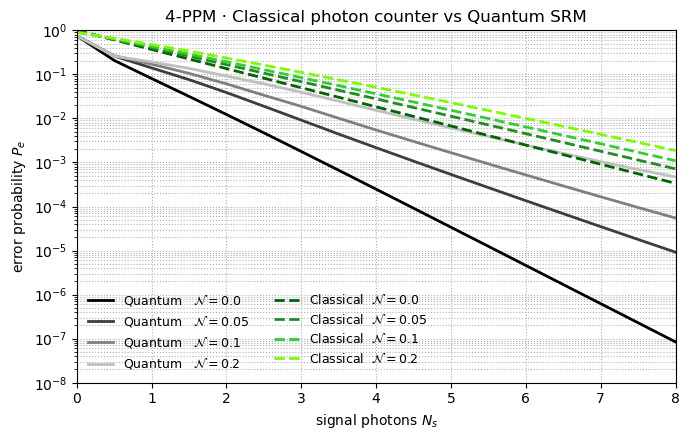

In [ ]:
# ================================================================
#  Section 6 · Joint plot  (Classical vs Quantum SRM)
# ================================================================

# ── alias any variable-name differences here ────────────────────
Ns_axis     = Ns_grid        # photon-count grid (identical in both scripts)
Pe_cl       = Pe_classic     # classical curves dict
Pe_qm       = Pe_quantum     # quantum SRM curves dict
N_levels    = noise_levels   # [0, 0.05, 0.10, 0.20]

# ── colour palettes (dark → light) ──────────────────────────────
greens = ['#006400', '#228B22', '#32CD32', '#7CFC00']
blacks = ['#000000', '#3d3d3d', '#7f7f7f', '#bfbfbf']

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4.5))

# Quantum SRM  (solid black/gray)
for col, N in zip(blacks, N_levels):
    plt.semilogy(Ns_axis,
                 Pe_qm[N],
                 color=col, lw=2,
                 label=rf"Quantum   $\mathcal{{N}}={N}$")

# Classical   (dashed green)
for col, N in zip(greens, N_levels):
    plt.semilogy(Ns_axis,
                 Pe_cl[N],
                 color=col, lw=2, ls='--',
                 label=rf"Classical  $\mathcal{{N}}={N}$")

# ── cosmetics ───────────────────────────────────────────────────
plt.xlabel(r"signal photons $N_s$")
plt.ylabel(r"error probability $P_e$")
plt.title("4-PPM · Classical photon counter vs Quantum SRM")
plt.xlim(0, 8); plt.ylim(1e-8, 1)
plt.grid(True, which='both', ls=':')
plt.legend(ncol=2, frameon=False, fontsize=9)   # 8-entry legend
plt.tight_layout()
plt.show()
